# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1s4_m9su
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1s4_m9su
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


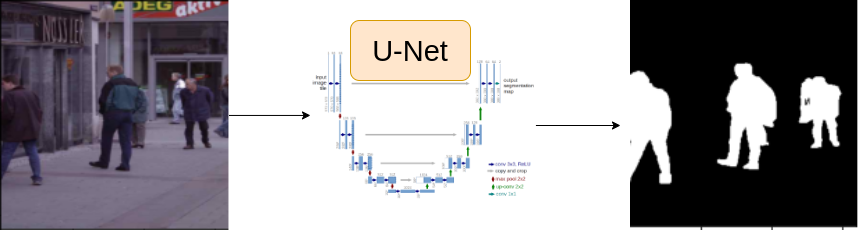

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_File = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_Dir = '/content/'

Device = 'cuda'

Epochs = 25
LR = 0.003
Image_Size = 320
Batch_Size = 16

Encoder = 'timm-efficientnet-b0'
Weights = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_File)
df

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
...,...,...
285,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
286,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
287,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
288,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[1]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

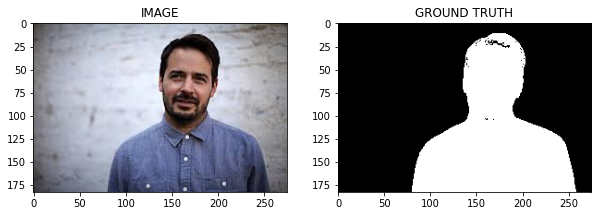

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(Image_Size, Image_Size),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes=False)


def get_valid_augs():
  return A.Compose([
      A.Resize(Image_Size, Image_Size),
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1 )

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask)/ 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())


In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


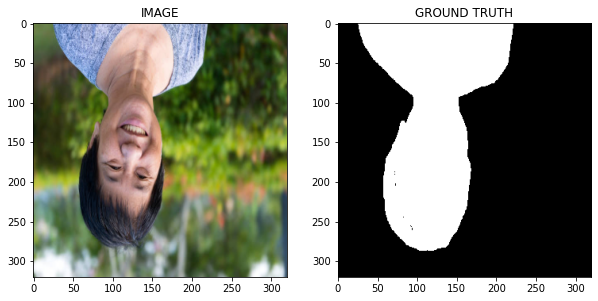

In [ ]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=Batch_Size, shuffle= True)
validloader = DataLoader(validset, batch_size=Batch_Size)


In [ ]:
print("Total No of Batches in Trainloader: ", len(trainloader))
print("Total No of Batches in Validloader: ", len(validloader))


Total No of Batches in Trainloader:  15
Total No of Batches in Validloader:  4


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel (nn.Module):
  def __init__(self):
    super (SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = Encoder, 
        encoder_weights=Weights,
        in_channels=3,
        classes= 1, 
        activation= None
    )

  def forward (self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode= 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2
    return logits

In [ ]:
model = SegmentationModel()
model.to(Device)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function 

In [ ]:
def trainfunc(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(Device)
    masks = masks.to(Device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def evalfun(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(Device)
      masks = masks.to(Device)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_los = np.Inf
for i in range(Epochs):
  train_loss = trainfunc(trainloader, model, optimizer)
  valid_loss = evalfun(validloader, model)

  if valid_loss < best_valid_los:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Model Saved')
    best_valid_los = valid_loss

  print('Epoch: ', i+1, 'Train Loss: ', train_loss, 'Valid Loss: ', valid_loss)

100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


Model Saved
Epoch:  1 Train Loss:  0.7975464999675751 Valid Loss:  2.111914098262787


100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


Model Saved
Epoch:  2 Train Loss:  0.3822902242342631 Valid Loss:  0.4556576535105705


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


Model Saved
Epoch:  3 Train Loss:  0.35460762480894725 Valid Loss:  0.30443108454346657


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Model Saved
Epoch:  4 Train Loss:  0.27720155914624534 Valid Loss:  0.2887999638915062


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch:  5 Train Loss:  0.25787738859653475 Valid Loss:  0.29597656428813934


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Model Saved
Epoch:  6 Train Loss:  0.24073533018430074 Valid Loss:  0.25193754583597183


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


Model Saved
Epoch:  7 Train Loss:  0.21851396858692168 Valid Loss:  0.2406470701098442


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch:  8 Train Loss:  0.2412189359466235 Valid Loss:  0.2998291477560997


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch:  9 Train Loss:  0.2579395184914271 Valid Loss:  0.2811281308531761


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch:  10 Train Loss:  0.16186251839001972 Valid Loss:  0.3054480813443661


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Epoch:  11 Train Loss:  0.1599390928943952 Valid Loss:  0.268461138010025


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Model Saved
Epoch:  12 Train Loss:  0.14610358228286108 Valid Loss:  0.21281789615750313


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Model Saved
Epoch:  13 Train Loss:  0.1389377474784851 Valid Loss:  0.18416086956858635


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch:  14 Train Loss:  0.14405875851710637 Valid Loss:  0.2281317450106144


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


Epoch:  15 Train Loss:  0.17474774767955145 Valid Loss:  0.27889879047870636


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


Epoch:  16 Train Loss:  0.1690732330083847 Valid Loss:  0.21931792050600052


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Epoch:  17 Train Loss:  0.1585639292995135 Valid Loss:  0.19701291248202324


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch:  18 Train Loss:  0.1481675868233045 Valid Loss:  0.19861675426363945


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


Epoch:  19 Train Loss:  0.15996496478716532 Valid Loss:  0.2379869744181633


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epoch:  20 Train Loss:  0.14300113370021184 Valid Loss:  0.1884964108467102


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch:  21 Train Loss:  0.11342602074146271 Valid Loss:  0.19708009250462055


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch:  22 Train Loss:  0.11989825963973999 Valid Loss:  0.19561739265918732


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Model Saved
Epoch:  23 Train Loss:  0.10494198352098465 Valid Loss:  0.18113214895129204


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch:  24 Train Loss:  0.1002280260125796 Valid Loss:  0.23628978617489338


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

Epoch:  25 Train Loss:  0.0877118522922198 Valid Loss:  0.2131756842136383


# Task 9 : Inference

In [ ]:
idx = 30

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(Device).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

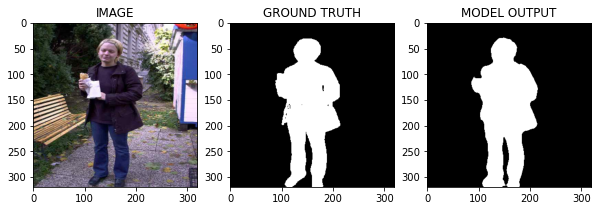

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))